In [12]:

# Load sentences
df = pd.read_csv('smiles_masked.csv', header=None)
sentences = [df[1].tolist()[1]]
print(sentences)


['<s><mask>(C<mask>N(CCC#<mask>)C(=O)c1cccc(-n2<mask>2)<mask>1</s>']


In [29]:
# Load in smiles CSV and sample 

import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM
import os

# Load model/tokenizer
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModelForMaskedLM.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model.eval()

# Load sentences
df = pd.read_csv('smiles_masked.csv', header=None)
sentences = df[1].tolist()[2:]
print(sentences)

# Parameters
n_steps = 101
save_every = 10 # Save every N steps
use_dmala = False
alpha = 0.15 if use_dmala else 0.15 # should be 0.15 for DMALA on infilling
N = tokenizer.vocab_size
print(N)

# Create output dir
os.makedirs("step_outputs_chem", exist_ok=True)

for sentence_idx, sentence in enumerate(sentences):
    #print(f"\nProcessing sentence {sentence_idx+1}/{len(sentences)}")
    
    input_ids = tokenizer.encode(sentence, return_tensors='pt')
    mask_positions = [i for i, token in enumerate(input_ids[0]) if token == tokenizer.mask_token_id]
    m = len(mask_positions)

    if m == 0:
        print("No mask tokens found. Skipping.")
        continue

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    logits_masked = [logits[0, pos, :] for pos in mask_positions]
    theta = [torch.argmax(logits_masked[i]).item() for i in range(m)]

    def compute_U(theta, logits_masked):
        log_probs = sum(torch.log_softmax(logits_masked[i], dim=0)[theta[i]] for i in range(m))
        return log_probs.item()

    def compute_proposal(i, theta, logits_masked, alpha):
        k = theta[i]
        scores = torch.full((N,), float('-inf'))
        scores[k] = 0
        mask = torch.ones(N, dtype=bool)
        mask[k] = False
        scores[mask] = 0.5 * (logits_masked[i][mask] - logits_masked[i][k]) - 1 / alpha
        return torch.softmax(scores, dim=0)

    for step in range(n_steps):
        theta_prime = []
        log_q_forward = 0
        for i in range(m):
            probs = compute_proposal(i, theta, logits_masked, alpha)
            k_prime = torch.multinomial(probs, 1).item()
            theta_prime.append(k_prime)
            log_q_forward += torch.log(probs[k_prime] + 1e-10).item()

        U_theta = compute_U(theta, logits_masked)
        U_theta_prime = compute_U(theta_prime, logits_masked)

        if use_dmala:
            log_q_backward = 0
            for i in range(m):
                probs_back = compute_proposal(i, theta_prime, logits_masked, alpha)
                log_q_backward += torch.log(probs_back[theta[i]] + 1e-10).item()
            log_accept = U_theta_prime - U_theta + log_q_backward - log_q_forward
            accept_prob = min(1, np.exp(log_accept))
            if np.random.rand() < accept_prob:
                theta = theta_prime
        else:
            accept_prob = 1.0
            theta = theta_prime

        # Save output for this step if it's a save step
        if step % save_every == 0:
            tokens = input_ids[0].tolist()
            for pos, word_idx in zip(mask_positions, theta):
                tokens[pos] = word_idx
            decoded = tokenizer.decode(tokens, skip_special_tokens=True)

            save_path = f"step_outputs_chem/step_{step}.csv"
            mode = 'a' if os.path.exists(save_path) else 'w'
            df_out = pd.DataFrame([[decoded, accept_prob]])
            df_out.to_csv(save_path, mode=mode, header=not os.path.exists(save_path), index=False)

print("\n✅ All step outputs saved to /step_outputs_chem/")

Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['<s>COc1ccc<mask><mask>(=O<mask>Nc2cc(F)c(OC)c(F<mask>c<mask>)cc1</s>', '<s>Cc<mask><mask>(C<mask>cc(N(C)C<mask>O)N[C@H]2C=C[<mask>@@H](C(=O<mask>O-])<mask>2)<mask>1</s>', '<s><mask>1ccccc1C[NH<mask>+][C@H]1CCO[<mask><mask>2<mask>CCOC2)C1</s>', '<s>O=C([O-])<mask><mask>cccc(Oc2ncnc<mask>c2CCCCC<mask>)c1</s>', '<s><mask>[C@@H](/C([<mask>-])=<mask>/c1ccccc1F<mask>N1CCC([C@@H](O<mask><mask>2nccn2<mask>)CC1</s>', '<s>C#CCOCC1<mask>(<mask>(=O)CCC2<mask>2)CC1</s>', '<s>CN(<mask><mask>c1[nH+]cccc1<mask><mask>CCc2nc(-c3cnccn3<mask>nH]c(=O)c2<mask>1</s>', '<s>CCNC(=O)c1ccc(<mask>(=O<mask>O)C[C@H<mask>C)c2ccccc<mask>)<mask>1</s>', '<s>Cc<mask>cc<mask>C[NH+]2CCO[C<mask>3<mask>CCc4<mask>43)C2)<mask>1-n1cncn1</s>', '<s>CNS(=<mask>)(=O)c1cc<mask>NC(=O)CSc2cccc<mask>C<mask><mask>2)ccc1C</s>', '<s>C[C@@H]([<mask>2+][C@<mask>](C)c1nnc<mask>ccccn12)<mask>1ccccc1N<mask><mask>)C</s>', '<s>CCOc1<mask>1<mask>(=O)C<mask>=C(C<mask>Nc2nnnn2[C@H]<mask>c1cc(Br)ccc<mask>OCC</s>', '<s>[NH-]S(=O<mask>O)c<mask>cnc(

In [ ]:
# How to 

Checking 0


[12:35:27] SMILES Parse Error: syntax error while parsing: 0
[12:35:27] SMILES Parse Error: check for mistakes around position 1:
[12:35:27] 0
[12:35:27] ^
[12:35:27] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[12:35:27] Explicit valence for atom # 14 N, 5, is greater than permitted
[12:35:27] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23
[12:35:27] SMILES Parse Error: extra close parentheses while parsing: C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1
[12:35:27] SMILES Parse Error: check for mistakes around position 48:
[12:35:27] ](C)C(=O)NC3CCCC3)C2)cc1
[12:35:27] ~~~~~~~~~~~~~~~~~~~~^
[12:35:27] SMILES Parse Error: Failed parsing SMILES 'C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1' for input: 'C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1'
[12:35:27] SMILES Parse Error: unclosed ring for input: 'C[NH+]C[C@@H]1CC[C@@H]1CN(C(=O)C[C@@H]1CC[NH+](CC3CCCC3)C1)CC2'
[12:35:27] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(N(Cc

Checking 10
Checking 20


[12:35:28] SMILES Parse Error: syntax error while parsing: 0
[12:35:28] SMILES Parse Error: check for mistakes around position 1:
[12:35:28] 0
[12:35:28] ^
[12:35:28] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[12:35:28] SMILES Parse Error: syntax error while parsing: COc1ccccc1C[NH2+][C@H]1CCO[NH+](2(CCOC2)C1
[12:35:28] SMILES Parse Error: check for mistakes around position 33:
[12:35:28] NH2+][C@H]1CCO[NH+](2(CCOC2)C1
[12:35:28] ~~~~~~~~~~~~~~~~~~~~^
[12:35:28] SMILES Parse Error: Failed parsing SMILES 'COc1ccccc1C[NH2+][C@H]1CCO[NH+](2(CCOC2)C1' for input: 'COc1ccccc1C[NH2+][C@H]1CCO[NH+](2(CCOC2)C1'
[12:35:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23
[12:35:28] SMILES Parse Error: extra close parentheses while parsing: CC[NH+]1CCC([C@@H](C)CNC(=O)Cc2cccCCOn3cccn3)cc2)CC1
[12:35:28] SMILES Parse Error: check for mistakes around position 49:
[12:35:28] Cc2cccCCOn3cccn3)cc2)CC1
[12:35:28] ~~~~~~~~~~~~~~~~~~~~^
[12:35:28] SMILES Parse Error: Failed parsing 

Checking 30
Checking 40


[12:35:28] SMILES Parse Error: syntax error while parsing: 0
[12:35:28] SMILES Parse Error: check for mistakes around position 1:
[12:35:28] 0
[12:35:28] ^
[12:35:28] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[12:35:28] SMILES Parse Error: syntax error while parsing: Nc1ccccc1C[NH2+][C@H]1CCO[NH+](2(CCOC2)C1
[12:35:28] SMILES Parse Error: check for mistakes around position 32:
[12:35:28] NH2+][C@H]1CCO[NH+](2(CCOC2)C1
[12:35:28] ~~~~~~~~~~~~~~~~~~~~^
[12:35:28] SMILES Parse Error: Failed parsing SMILES 'Nc1ccccc1C[NH2+][C@H]1CCO[NH+](2(CCOC2)C1' for input: 'Nc1ccccc1C[NH2+][C@H]1CCO[NH+](2(CCOC2)C1'
[12:35:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23
[12:35:28] SMILES Parse Error: extra close parentheses while parsing: C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1
[12:35:28] SMILES Parse Error: check for mistakes around position 48:
[12:35:28] ](C)C(=O)NC3CCCC3)C2)cc1
[12:35:28] ~~~~~~~~~~~~~~~~~~~~^
[12:35:28] SMILES Parse Error: Failed parsing SMIL

Checking 50
Checking 60


[12:35:28] SMILES Parse Error: syntax error while parsing: 0
[12:35:28] SMILES Parse Error: check for mistakes around position 1:
[12:35:28] 0
[12:35:28] ^
[12:35:28] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[12:35:28] SMILES Parse Error: syntax error while parsing: COc1ccccc1C[NH2+][C@H]1CCO[NH@@2(CCOC2)C1
[12:35:28] SMILES Parse Error: check for mistakes around position 30:
[12:35:28] 1C[NH2+][C@H]1CCO[NH@@2(CCOC2)C1
[12:35:28] ~~~~~~~~~~~~~~~~~~~~^
[12:35:28] SMILES Parse Error: Failed parsing SMILES 'COc1ccccc1C[NH2+][C@H]1CCO[NH@@2(CCOC2)C1' for input: 'COc1ccccc1C[NH2+][C@H]1CCO[NH@@2(CCOC2)C1'
[12:35:28] SMILES Parse Error: unclosed ring for input: '[NH-]S(=O)(=O)cCCCCCCCCcnc(N2CCN([C@H]3C[C@H]4CC[C@@H]3C4)CC2)s1'
[12:35:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23
[12:35:28] SMILES Parse Error: extra close parentheses while parsing: C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1
[12:35:28] SMILES Parse Error: check for mistakes around positio

Checking 70
Checking 80


[12:35:28] SMILES Parse Error: syntax error while parsing: 0
[12:35:28] SMILES Parse Error: check for mistakes around position 1:
[12:35:28] 0
[12:35:28] ^
[12:35:28] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[12:35:28] SMILES Parse Error: syntax error while parsing: COc1ccccc1C[NH2+][C@H]1CCO[NH@]2(CCOC2)C1
[12:35:28] SMILES Parse Error: check for mistakes around position 30:
[12:35:28] 1C[NH2+][C@H]1CCO[NH@]2(CCOC2)C1
[12:35:28] ~~~~~~~~~~~~~~~~~~~~^
[12:35:28] SMILES Parse Error: Failed parsing SMILES 'COc1ccccc1C[NH2+][C@H]1CCO[NH@]2(CCOC2)C1' for input: 'COc1ccccc1C[NH2+][C@H]1CCO[NH@]2(CCOC2)C1'
[12:35:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23
[12:35:28] SMILES Parse Error: extra close parentheses while parsing: C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1
[12:35:28] SMILES Parse Error: check for mistakes around position 48:
[12:35:28] ](C)C(=O)NC3CCCC3)C2)cc1
[12:35:28] ~~~~~~~~~~~~~~~~~~~~^
[12:35:28] SMILES Parse Error: Failed parsing SM

Checking 90
Checking 100


[12:35:29] SMILES Parse Error: syntax error while parsing: 0
[12:35:29] SMILES Parse Error: check for mistakes around position 1:
[12:35:29] 0
[12:35:29] ^
[12:35:29] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[12:35:29] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C(=O)Nc2cc(F)c(OC)c(F)c23)cc1'
[12:35:29] SMILES Parse Error: syntax error while parsing: Oc1ccccc1C[NH2+][C@H]1CCO[NH@]2(CCOC2)C1
[12:35:29] SMILES Parse Error: check for mistakes around position 29:
[12:35:29] 1C[NH2+][C@H]1CCO[NH@]2(CCOC2)C1
[12:35:29] ~~~~~~~~~~~~~~~~~~~~^
[12:35:29] SMILES Parse Error: Failed parsing SMILES 'Oc1ccccc1C[NH2+][C@H]1CCO[NH@]2(CCOC2)C1' for input: 'Oc1ccccc1C[NH2+][C@H]1CCO[NH@]2(CCOC2)C1'
[12:35:29] Explicit valence for atom # 9 C, 4, is greater than permitted
[12:35:29] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23
[12:35:29] SMILES Parse Error: syntax error while parsing: COCC1(C(=O)NCc2cccnc2N[C)CCO)CCC1
[12:35:29] SMILES Parse Error: check for mistakes 

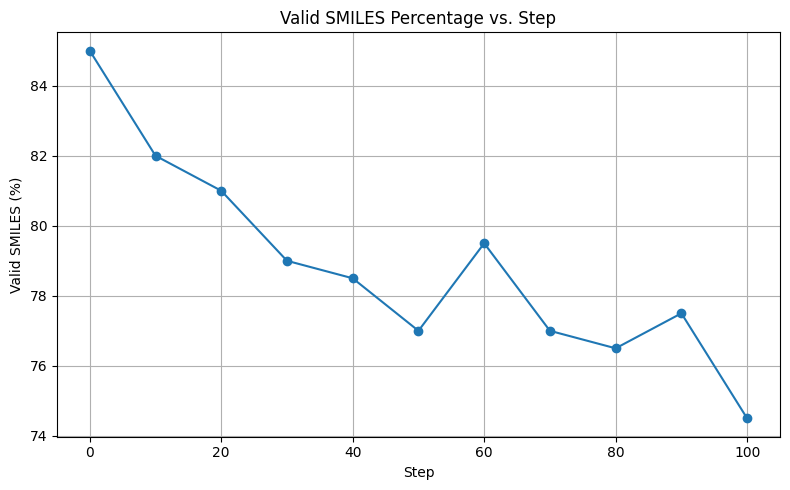

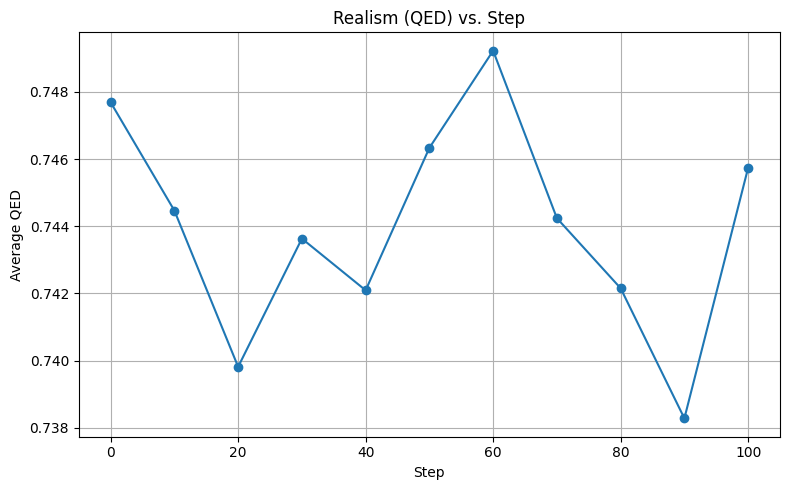

[85.0, 82.0, 81.0, 79.0, 78.5, 77.0, 79.5, 77.0, 76.5, 77.5, 74.5]
[0.7476899221826905, 0.7444667541946791, 0.7398167513245907, 0.7436338722104374, 0.7420945421606129, 0.7463349189225194, 0.7492262451418749, 0.7442419763866388, 0.7421559936430552, 0.7382837475007142, 0.7457404768203789]


In [30]:
import pandas as pd
import glob
import os
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import QED

step_dir = "step_outputs_chem"
step_files = sorted(glob.glob(os.path.join(step_dir, 'step_*.csv')),
                    key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[1]))

steps, valid_pct, avg_qed = [], [], []

for fpath in step_files:
    step_num = int(os.path.splitext(os.path.basename(fpath))[0].split('_')[1])
    print(f"Checking {step_num}")
    df_step = pd.read_csv(fpath, header=None, names=['smiles', 'accept_prob'])
    smiles_list = df_step['smiles'].tolist()

    # Validity check
    valid = [Chem.MolFromSmiles(s) for s in smiles_list]
    is_valid = [mol is not None for mol in valid]
    pct = 100 * sum(is_valid) / len(is_valid)

    # Realism: average QED on valid molecules
    qed_scores = [QED.qed(mol) for mol in valid if mol is not None]
    avg = sum(qed_scores) / len(qed_scores) if qed_scores else 0

    steps.append(step_num)
    valid_pct.append(pct)
    avg_qed.append(avg)

# Plot Valid SMILES Percentage vs Step
plt.figure(figsize=(8, 5))
plt.plot(steps, valid_pct, marker='o')
plt.xlabel('Step')
plt.ylabel('Valid SMILES (%)')
plt.title('Valid SMILES Percentage vs. Step')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Average QED (Realism) vs Step
plt.figure(figsize=(8, 5))
plt.plot(steps, avg_qed, marker='o')
plt.xlabel('Step')
plt.ylabel('Average QED')
plt.title('Realism (QED) vs. Step')
plt.grid(True)
plt.tight_layout()
plt.show()

print(valid_pct)
print(avg_qed)


[16:13:24] SMILES Parse Error: syntax error while parsing: 0
[16:13:24] SMILES Parse Error: check for mistakes around position 1:
[16:13:24] 0
[16:13:24] ^
[16:13:24] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[16:13:24] Explicit valence for atom # 14 N, 5, is greater than permitted
[16:13:24] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23
[16:13:24] SMILES Parse Error: extra close parentheses while parsing: C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1
[16:13:24] SMILES Parse Error: check for mistakes around position 48:
[16:13:24] ](C)C(=O)NC3CCCC3)C2)cc1
[16:13:24] ~~~~~~~~~~~~~~~~~~~~^
[16:13:24] SMILES Parse Error: Failed parsing SMILES 'C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1' for input: 'C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1'
[16:13:24] SMILES Parse Error: unclosed ring for input: 'C[NH+]C[C@@H]1CC[C@@H]1CN(C(=O)C[C@@H]1CC[NH+](CC3CCCC3)C1)CC2'
[16:13:24] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(N(Cc

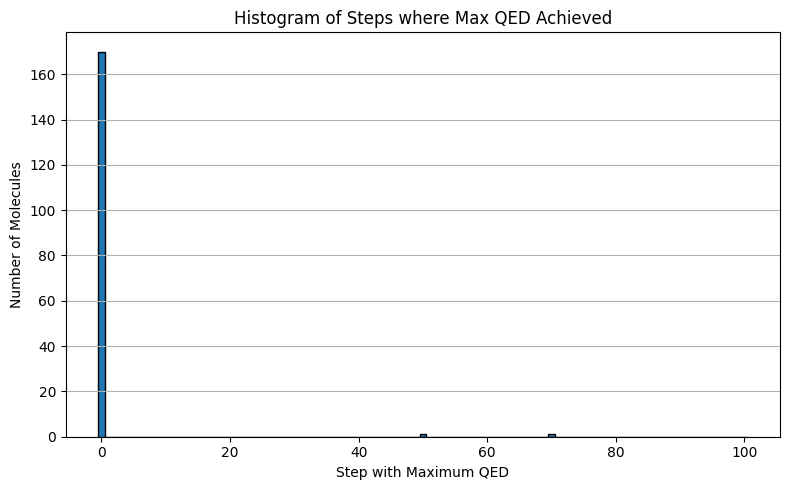

In [29]:

# First, collect QED per molecule across steps
qed_by_molecule = dict()  # molecule index -> (step, qed)

for fpath in step_files:
    step_num = int(os.path.splitext(os.path.basename(fpath))[0].split('_')[1])
    df_step = pd.read_csv(fpath, header=None, names=['smiles', 'accept_prob'])
    smiles_list = df_step['smiles'].tolist()

    for idx, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            qed_score = QED.qed(mol)
            if idx not in qed_by_molecule:
                qed_by_molecule[idx] = []
            qed_by_molecule[idx].append((step_num, qed_score))

# Now, for each molecule, find step with maximum QED
max_qed_steps = []
for idx, step_qed_list in qed_by_molecule.items():
    if step_qed_list:
        max_step = max(step_qed_list, key=lambda x: x[1])[0]  # Get step with max QED
        max_qed_steps.append(max_step)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(max_qed_steps, bins=range(min(steps), max(steps)+2), edgecolor='black', align='left')
plt.xlabel('Step with Maximum QED')
plt.ylabel('Number of Molecules')
plt.title('Histogram of Steps where Max QED Achieved')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# THis doens't work

import os
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM

def continuous_mala_sampling(
    sentences,
    tokenizer,
    model,
    n_steps=100,
    eps=1e-3,
    sigma=1.0,
    save_every=10,
    output_dir="step_outputs_continuous_mala"
):
    """
    Perform continuous MALA sampling in logit space for masked SMILES.

    For every `save_every` steps, writes a CSV `step_{step}.csv` in `output_dir`
    containing one row per input sentence: [decoded_smiles, accept_prob].
    """
    os.makedirs(output_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # Prepare a dict of open file flags
    for step in range(0, n_steps, save_every):
        step_path = os.path.join(output_dir, f"step_{step}.csv")
        # Ensure header exists
        if not os.path.exists(step_path):
            with open(step_path, 'w') as f:
                f.write('decoded,accept_prob\n')

    for idx, sentence in enumerate(sentences):
        # Tokenize and find mask positions
        input_ids = tokenizer.encode(sentence, return_tensors="pt").to(device)
        mask_token_id = tokenizer.mask_token_id
        mask_positions = [i for i, t in enumerate(input_ids[0]) if t.item() == mask_token_id]
        if not mask_positions:
            continue

        # Initial logits from the LM
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits.squeeze(0)  # (seq_len, V)
        x_current = torch.stack([logits[pos] for pos in mask_positions], dim=0).detach()

        def compute_U_and_grad(x_state):
            x_state = x_state.clone().requires_grad_(True)
            # Log-likelihood: marginalize via log-sum-exp
            logp = torch.log_softmax(x_state, dim=-1)
            logp_marginal = torch.logsumexp(logp, dim=-1).sum()
            prior = (x_state**2).sum() / (2 * sigma**2)
            U = -logp_marginal + prior
            grad = torch.autograd.grad(U, x_state)[0]
            return U, grad

        # MALA sampling
        for step in range(n_steps):
            U_curr, grad_curr = compute_U_and_grad(x_current)
            noise = torch.randn_like(x_current)
            x_prop = x_current - 0.5 * eps * grad_curr + noise * np.sqrt(eps)
            U_prop, grad_prop = compute_U_and_grad(x_prop)

            # Compute transition log-probs
            def log_q(x_from, x_to, grad_from):
                diff = x_to - x_from + 0.5 * eps * grad_from
                return - (diff**2).sum() / (4 * eps)

            log_q_fwd = log_q(x_current, x_prop, grad_curr)
            log_q_bwd = log_q(x_prop, x_current, grad_prop)

            log_alpha = -U_prop + U_curr + log_q_bwd - log_q_fwd
            accept_prob = float(min(1.0, torch.exp(log_alpha).item()))

            if torch.log(torch.rand(()).to(device)) < log_alpha:
                x_current = x_prop.detach()
            else:
                x_current = x_current.detach()

            # Save output every save_every steps
            if step % save_every == 0:
                # Decode current state
                probs = torch.softmax(x_current, dim=-1)
                tokens = input_ids[0].tolist()
                for i, pos in enumerate(mask_positions):
                    tokens[pos] = int(probs[i].argmax().item())
                decoded = tokenizer.decode(tokens, skip_special_tokens=True)

                # Append to CSV for this step
                step_path = os.path.join(output_dir, f"step_{step}.csv")
                with open(step_path, 'a') as f:
                    f.write(f"{decoded},{accept_prob}\n")

    print(f"✅ Continuous MALA outputs saved to {output_dir}")

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModelForMaskedLM.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
df = pd.read_csv("smiles_masked.csv", header=None)
sentences = df[1].tolist()[2:]
continuous_mala_sampling(
    sentences,
    tokenizer,
    model,
    n_steps=101,
    eps=0.1,
    sigma=1.0,
    save_every=10,
    output_dir="step_outputs_continuous_mala"
)


Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ Continuous MALA outputs saved to step_outputs_continuous_mala


[12:14:58] SMILES Parse Error: syntax error while parsing: 0
[12:14:58] SMILES Parse Error: check for mistakes around position 1:
[12:14:58] 0
[12:14:58] ^
[12:14:58] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[12:14:58] Explicit valence for atom # 14 N, 5, is greater than permitted
[12:14:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23
[12:14:58] SMILES Parse Error: extra close parentheses while parsing: C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1
[12:14:58] SMILES Parse Error: check for mistakes around position 48:
[12:14:58] ](C)C(=O)NC3CCCC3)C2)cc1
[12:14:58] ~~~~~~~~~~~~~~~~~~~~^
[12:14:58] SMILES Parse Error: Failed parsing SMILES 'C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1' for input: 'C#CCCOc1ccc(C[NH+]2CCC[C@@H](C)C(=O)NC3CCCC3)C2)cc1'
[12:14:58] SMILES Parse Error: unclosed ring for input: 'C[NH+]C[C@@H]1CC[C@@H]1CN(C(=O)C[C@@H]1CC[NH+](CC3CCCC3)C1)CC2'
[12:14:58] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(N(Cc

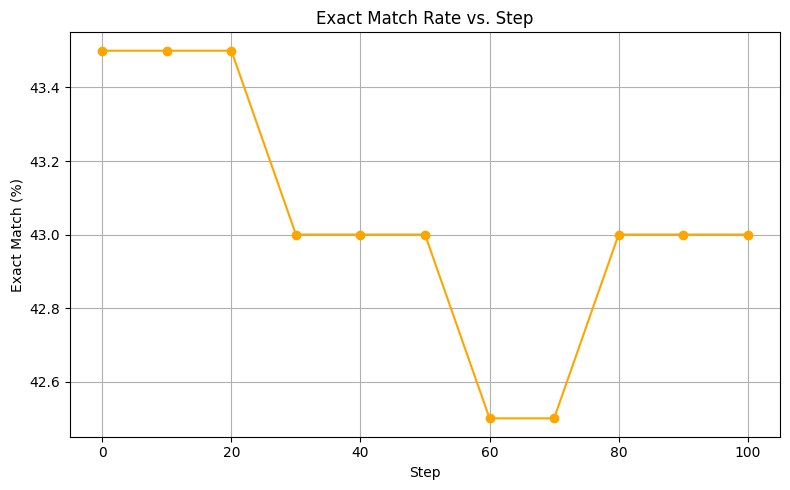

[43.5, 43.5, 43.5, 43.0, 43.0, 43.0, 42.5, 42.5, 43.0, 43.0, 43.0]


In [22]:
# Load reference SMILES
ref_df = pd.read_csv("smiles_masked.csv")
ref_smiles = set(ref_df["smiles"].dropna().tolist())  # set for fast lookup

exact_match_pct = []

for fpath in step_files:
    step_num = int(os.path.splitext(os.path.basename(fpath))[0].split('_')[1])
    df_step = pd.read_csv(fpath, header=None, names=['smiles', 'accept_prob'])
    smiles_list = df_step['smiles'].tolist()

    # Validity check
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    valid_smiles = [s for s, m in zip(smiles_list, mols) if m is not None]
    # Count exact matches
    matches = [s for s in valid_smiles if s in ref_smiles]
    pct_match = 100 * len(matches) / 200 if valid_smiles else 0
    exact_match_pct.append(pct_match)

plt.figure(figsize=(8, 5))
plt.plot(steps, exact_match_pct, marker='o', color='orange')
plt.xlabel('Step')
plt.ylabel('Exact Match (%)')
plt.title('Exact Match Rate vs. Step')
plt.grid(True)
plt.tight_layout()
plt.show()

print(exact_match_pct)

In [23]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

# Load reference SMILES in order
ref_df = pd.read_csv("smiles_masked.csv")
ref_smiles = ref_df["smiles"].dropna().tolist()

avg_tanimoto_per_step = []

for fpath in step_files:
    step_num = int(os.path.splitext(os.path.basename(fpath))[0].split('_')[1])
    df_step = pd.read_csv(fpath, header=None, names=['smiles', 'accept_prob'])
    gen_smiles = df_step['smiles'].tolist()

    # Truncate to same length
    paired = list(zip(ref_smiles, gen_smiles))
    
    tanimoto_scores = []
    for ref_smi, gen_smi in paired:
        ref_mol = Chem.MolFromSmiles(ref_smi)
        gen_mol = Chem.MolFromSmiles(gen_smi)
        if ref_mol is not None and gen_mol is not None:
            ref_fp = AllChem.GetMorganFingerprintAsBitVect(ref_mol, 2, nBits=2048)
            gen_fp = AllChem.GetMorganFingerprintAsBitVect(gen_mol, 2, nBits=2048)
            sim = DataStructs.TanimotoSimilarity(ref_fp, gen_fp)
            tanimoto_scores.append(sim)

    avg_sim = 100 * sum(tanimoto_scores) / len(tanimoto_scores) if tanimoto_scores else 0
    avg_tanimoto_per_step.append(avg_sim)

print(avg_tanimoto_per_step)



[12:16:14] SMILES Parse Error: syntax error while parsing: 0
[12:16:14] SMILES Parse Error: check for mistakes around position 1:
[12:16:14] 0
[12:16:14] ^
[12:16:14] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] Explicit valence for atom # 14 N, 5, is greater than permitted
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use MorganGenerator
[12:16:14] DEPRECATION WARNING: please use Morgan

[85.93758563977134, 85.93758563977134, 85.93758563977134, 85.79223680256204, 85.78871759028219, 85.63605005702448, 85.75275362802076, 85.75275362802076, 85.83558645576483, 85.65252911594344, 85.73498584516216]


[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] DEPRECATION WARNING: please use MorganGenerator
[12:16:15] SMILES Parse Error: unclosed ring for input: 'CC(C)CCNC(=O)[C@@]1(C)CN(S(=O)(=O)c2ccccc2)C(=O)N1CCc2cccs21'
[12:16:15] DEPRECATION WARNING: please use MorganGenera